# Left Ventricle Full Quantification (LVQuan18) Challenge MICCAI 2018

Accurate cardiac left ventricle (LV) quantification is among the most clinically important and most frequently demanded tasks for identification and diagnosis of cardiac diseases and is of great interest in the research community of medical image analysis.

### The task

The focus will be on full quantification of LV, i.e., all clinical significant LV indices regarding to the anatomical structure of LV are investigated in addition to the frequently studied LV volume. Fig.1 below shows visually these indices.
These are:
1. Areas of LV cavity and myocardium : $A_{1}$ and $A_{2}$ (see Fig.1(a))
2. Dimensions of LV cavity: $D_{1}, D_{2}$ and $D_{3}$ (see Fig.1(b))
3. Reginal wall thickness of myocardium: $RWT_{1}, ..., RWT_{6}$ (see Fig.1(c))
4. Cardiac phase: diastole (0) or systole(1) (see Fig.1(d))

 <figure>
  <img src="lvquan.jpg" width="600">
  <figcaption> <center> Figure 1. LV indices to find. Orange and green areas are respectively LV cavity and myocardium.
  </center> </figcaption>
</figure> 


### The dataset

A training dataset with processed SAX MR sequences of 145 subjects from clinical environment is used for model learning and validation.

For each subject, 20 frames are included for the whole cardiac cycle. All ground truth values of the above-mentioned LV indices are provided for every single frame. More details about the training dataset can be found in the document of the DIG-Cardiac dataset. 

In [66]:
import numpy as np
from matplotlib import pyplot as plt
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
%matplotlib inline
%reload_ext autoreload
%autoreload 2

PATH ='./'

## Dataset exploration

The provided dataset is a matlab file (.mat). 

Thus we're going to use scipy.io which can open this kind of file in python.

In [68]:
import scipy.io as sio

data = sio.loadmat(PATH+'cardiac-dig.mat')
data.keys()


dict_keys(['__header__', '__version__', '__globals__', 'areas', 'dims', 'endo_LV', 'epi_LV', 'images_LV', 'lv_phase', 'pix_spa', 'ratio_resize_inverse', 'rwt'])

In [49]:
f'{data["images_LV"].shape}, 2900 / 20 frames =  {2900/20} patients'

'(80, 80, 2900), 2900 / 20 frames =  145.0 patients'

In [33]:
n_diastolic = np.sum(data["lv_phase"] == 0) // 20
n_systolic = np.sum(data["lv_phase"] == 1) // 20
print(f'Number of sequences in diastolic phase :  {n_diastolic}')
print(f'Number of sequences in systolic phase  :  {n_systolic}')
print(f'Total                                  : {n_diastolic + n_systolic}')


Number of sequences in diastolic phase :  84
Number of sequences in systolic phase  :  61
Total                                  : 145


### Look at the first patient MR sequence 

In [51]:
patient = data['images_LV'][:,:,:20]
seg_endo = data['endo_LV'][:,:,:20]
seg_epi = data['epi_LV'][:,:,:20]

def get_sample(seq, size=3):
    return np.hstack([seq[:,:,i] for i in range(size)])

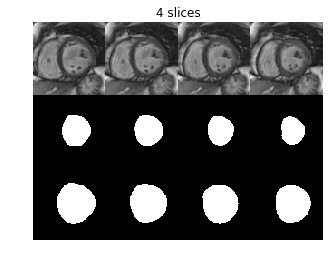

In [55]:
n = 4
slice_sample = get_sample(patient, n)
seg_endo_sample = get_sample(seg_endo, n)
seg_epi_sample = get_sample(seg_epi, n)
samples = np.vstack((slice_sample, seg_endo_sample, seg_epi_sample))
plt.imshow(samples, cmap='gray')
plt.title(f'{n} slices')
plt.axis("off")
plt.show()


In [81]:
print ('dims attribute', data['dims'].shape, data['dims'][:,0])
print ('areas attribute', data['areas'].shape, data['areas'][:,0])
print ('rwt attribute', data['rwt'].shape, data['rwt'][:,0])

dims attribute (3, 2900) [ 0.40795  0.4411   0.40617]
areas attribute (2, 2900) [ 0.13742  0.09059]
rwt attribute (6, 2900) [ 0.06005  0.04753  0.05253  0.05125  0.04902  0.06165]
